<a href="https://colab.research.google.com/github/samarth2015/CS203_Lab_4/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 1: Setup the dataset

- Load the MNIST dataset using the Hugging Face datasets library.
- Convert the image data into Numpy arrays and normalize pixel values to the range [0,1].
- Flatten each image into a vector of 784 features.
- Split the dataset into training and testing sets.
- Randomly select an initially labeled dataset of 200 samples from training samples.
- Generate an "Unlabeled Pool," the Initial Dataset excluding 200 samples.

In [96]:
!pip install datasets

In [97]:
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [98]:
data = datasets.load_dataset("mnist")

In [99]:
# convert the image data into a numpy array and normalize the values from 0 to 1
X = np.array(data['train']["image"]) / 255
y = np.array(data['train']["label"])


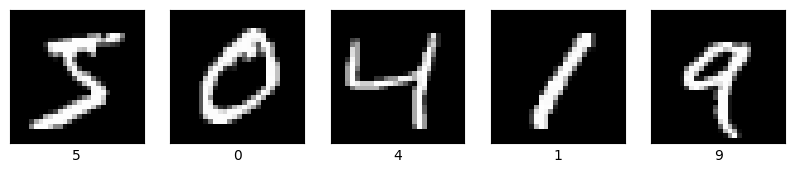

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))  # Adjusted size for 5 images in a row
for i in range(5):  # Looping only through the first 5 images
    plt.subplot(1, 5, i + 1)  # 1 row, 5 columns
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i].reshape(28, -1), cmap='gray')  # Assuming grayscale images
    plt.xlabel(y[i])  # Display corresponding label
plt.show()


In [101]:
X = X.reshape(X.shape[0], -1)
X.shape

(60000, 784)

In [102]:
X_test = np.array(data['test']["image"]) / 255
y_test = np.array(data['test']["label"])

# flatten the test data
X_test = X_test.reshape(X_test.shape[0], -1)

In [103]:
# randomly select 200 samples from training dataset and create a labelled dataset
np.random.seed(45)
idx = np.random.choice(X.shape[0], 200, replace=False)
X_train_labelled = X[idx]
y_train_labelled = y[idx]

In [104]:
# create a pool of unlabelled data
X_train_unlabelled = np.delete(X, idx, axis=0)
y_train_unlabelled = np.delete(y, idx, axis=0)

X_train_unlabelled.shape


(59800, 784)

## Task 2: Implement Random Sampling for Active Learning


- Train a Random Forest Classifier (you can use “from sklearn.ensemble import RandomForestClassifier”)  on the initial dataset of 200 samples.
- Implement an active learning loop for 20 iterations:
    - Randomly select a sample from the unlabeled pool.
    - Get the selected sample and its true label.
    - Add the sample and label to the labeled dataset.
    - Remove the selected sample and label from the pool.
    - Retrain the model on the updated dataset.
    - Check the model's accuracy on the test set.
    - Print accuracy after every iteration.


In [105]:
from sklearn.ensemble import RandomForestClassifier

# train a random forest classifier on the labelled data
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_labelled, y_train_labelled)

# predict the unlabelled data
y_prediction = clf.predict(X_test)

# calculate the accuracy of the classifier
accuracy = np.mean(y_test == y_prediction)
accuracy

0.7777

In [106]:
# implementing active learning by for 20 iterations by randomly choosing the samples from the unlabelled pool.
task1_results = []
index=[]
for i in range(20):
    idx_curr = np.random.choice(X_train_unlabelled.shape[0], 1, replace=False) # randomly select 1 sample
    index.append(idx_curr)

    # add the sample to the labelled dataset
    X_train_labelled = np.concatenate([X_train_labelled, X_train_unlabelled[idx_curr]])
    y_train_labelled = np.concatenate([y_train_labelled, y_train_unlabelled[idx_curr]])

    # remove the sample from the unlabelled dataset
    X_train_unlabelled = np.delete(X_train_unlabelled, idx_curr, axis=0)
    y_train_unlabelled = np.delete(y_train_unlabelled, idx_curr, axis=0)

    # retrain the classifier
    clf.fit(X_train_labelled, y_train_labelled)

    # predict the unlabelled data
    y_prediction= clf.predict(X_test)

    # calculate the accuracy of the classifier
    accuracy = np.mean(y_test == y_prediction)
    task1_results.append(accuracy)
    print(f"Iteration: {i} Accuracy: {accuracy}")

Iteration: 0 Accuracy: 0.7705
Iteration: 1 Accuracy: 0.7791
Iteration: 2 Accuracy: 0.7682
Iteration: 3 Accuracy: 0.7717
Iteration: 4 Accuracy: 0.776
Iteration: 5 Accuracy: 0.7863
Iteration: 6 Accuracy: 0.7662
Iteration: 7 Accuracy: 0.7782
Iteration: 8 Accuracy: 0.7798
Iteration: 9 Accuracy: 0.7889
Iteration: 10 Accuracy: 0.7819
Iteration: 11 Accuracy: 0.7795
Iteration: 12 Accuracy: 0.7835
Iteration: 13 Accuracy: 0.7845
Iteration: 14 Accuracy: 0.7868
Iteration: 15 Accuracy: 0.7984
Iteration: 16 Accuracy: 0.8022
Iteration: 17 Accuracy: 0.7971
Iteration: 18 Accuracy: 0.7862
Iteration: 19 Accuracy: 0.7971


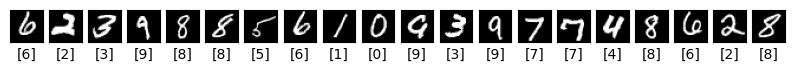

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))  # Adjusted size for 5 images in a row
for i in range(20):  # Looping only through the first 5 images
    plt.subplot(1, 20, i + 1)  # 1 row, 5 columns
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[index[i]].reshape(28, -1), cmap='gray')  # Assuming grayscale images
    plt.xlabel(y[index[i]])  # Display corresponding label
plt.show()


## Task 3: Implement Uncertainty Sampling for Active Learning.

- Train a Random Forest Classifier (you can use “from sklearn.ensemble import RandomForestClassifier”)  on the initial dataset of 200 samples.
- Implement an active learning loop for 20 iterations:
    - Compute uncertainty (Label Entropy) for each sample in the unlabeled pool using entropy.
    - Select the sample with the highest uncertainty and query its true label.
    - Add the queried sample to the labelled dataset and remove it from the unlabelled pool.
    - Retrain the model and check the model's accuracy on the test set.
    - Print accuracy after every iteration


In [108]:
np.random.seed(45)
idx = np.random.choice(X.shape[0], 200, replace=False)
X_train_labelled = X[idx]
y_train_labelled = y[idx]

X_train_unlabelled=np.delete(X,idx,axis=0)
y_train_unlabelled=np.delete(y,idx,axis=0)


In [109]:
X_train_unlabelled.shape
# Y_train_unlabelled.shape


(59800, 784)

In [110]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train_labelled,y_train_labelled)
y_prediction=clf.predict(X_test)
accuracy=np.mean(y_test==y_prediction)
accuracy

0.7777

In [111]:
def labelentropy(probability):
    max_entropy=float('-inf')
    epsilon=1e-10
    maxind=-1
    for i in range(len(probability)):
        ent=-np.sum(probability[i]*np.log10(probability[i]+epsilon))
        if(ent>max_entropy):
            max_entropy=ent
            maxind=i
    return [maxind]

In [112]:
X_train_unlabelled[0].shape

(784,)

In [113]:
task2_results=[]
ind1=[]
for i in range(20):
    probability=clf.predict_proba(X_train_unlabelled)
    idx_curr=labelentropy(probability)
    ind1.append(idx_curr)

    # add the sample to the labelled dataset
    X_train_labelled = np.concatenate([X_train_labelled, X_train_unlabelled[idx_curr]])
    y_train_labelled = np.concatenate([y_train_labelled, y_train_unlabelled[idx_curr]])

    # remove the sample from the unlabelled dataset
    X_train_unlabelled = np.delete(X_train_unlabelled, idx_curr, axis=0)
    y_train_unlabelled = np.delete(y_train_unlabelled, idx_curr, axis=0)

    # retrain the classifier
    clf.fit(X_train_labelled, y_train_labelled)

    # predict the unlabelled data
    y_prediction= clf.predict(X_test)

    # calculate the accuracy of the classifier
    accuracy = np.mean(y_test == y_prediction)
    task2_results.append(accuracy)
    print(f"Iteration: {i} Accuracy: {accuracy}")



Iteration: 0 Accuracy: 0.7726
Iteration: 1 Accuracy: 0.7711
Iteration: 2 Accuracy: 0.7844
Iteration: 3 Accuracy: 0.7796
Iteration: 4 Accuracy: 0.7779
Iteration: 5 Accuracy: 0.7785
Iteration: 6 Accuracy: 0.7799
Iteration: 7 Accuracy: 0.7667
Iteration: 8 Accuracy: 0.7749
Iteration: 9 Accuracy: 0.7783
Iteration: 10 Accuracy: 0.7833
Iteration: 11 Accuracy: 0.7794
Iteration: 12 Accuracy: 0.7967
Iteration: 13 Accuracy: 0.7949
Iteration: 14 Accuracy: 0.7759
Iteration: 15 Accuracy: 0.7903
Iteration: 16 Accuracy: 0.7824
Iteration: 17 Accuracy: 0.7838
Iteration: 18 Accuracy: 0.7874
Iteration: 19 Accuracy: 0.7933


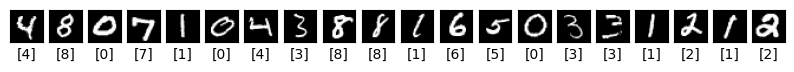

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))  # Adjusted size for 5 images in a row
for i in range(20):  # Looping only through the first 5 images
    plt.subplot(1, 20, i + 1)  # 1 row, 5 columns
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[ind1[i]].reshape(28, -1), cmap='gray')  # Assuming grayscale images
    plt.xlabel(y[ind1[i]])  # Display corresponding label
plt.show()


In [115]:
print(ind1)

[[2829], [37039], [32313], [36307], [49260], [24476], [32384], [45712], [12173], [52699], [42968], [43166], [47115], [53118], [14350], [13673], [32710], [41260], [57301], [17137]]


## Task 4: Implement Query-by-Committee for Active Learning

In [127]:
np.random.seed(45)
idx = np.random.choice(X.shape[0], 200, replace=False)
X_train_labelled = X[idx]
y_train_labelled = y[idx]

X_train_unlabelled=np.delete(X,idx,axis=0)
y_train_unlabelled=np.delete(y,idx,axis=0)

In [117]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train_labelled,y_train_labelled)
y_prediction=clf.predict(X_test)


In [118]:
clf1=RandomForestClassifier(n_estimators=100)
clf1.fit(X_train_labelled,y_train_labelled)
y_prediction=clf1.predict(X_test)


In [119]:
clf2=RandomForestClassifier(n_estimators=100)
clf2.fit(X_train_labelled,y_train_labelled)
y_prediction=clf2.predict(X_test)


In [120]:
clf3=RandomForestClassifier(n_estimators=100)
clf3.fit(X_train_labelled,y_train_labelled)
y_prediction=clf3.predict(X_test)


In [121]:
clf4=RandomForestClassifier(n_estimators=100)
clf4.fit(X_train_labelled,y_train_labelled)
y_prediction=clf4.predict(X_test)


In [122]:
print(len(X_train_unlabelled))

59800


In [131]:
def voteentropy(X_train_unlabelled, clf, clf1, clf2, clf3, clf4):
    # Stack the predictions from all classifiers into a 2D array
    predictions = np.array([
        clf.predict(X_train_unlabelled),
        clf1.predict(X_train_unlabelled),
        clf2.predict(X_train_unlabelled),
        clf3.predict(X_train_unlabelled),
        clf4.predict(X_train_unlabelled)
    ])
    # print(predictions.shape)
    # Transpose predictions to have shape (5, n_samples)
    predictions = predictions.T  # Now shape is (n_samples, 5)

    # Initialize an empty array for storing probabilities
    prob = np.zeros((predictions.shape[0], 10))

    # Add 0.2 for each prediction in the corresponding class
    for i in range(predictions.shape[0]):
        np.add.at(prob[i], predictions[i], 0.2)
    # print(prob[0])
    # print(predictions[0])
    # plt.imshow(X_train_unlabelled[0].reshape(28, -1))
    # plt.show()

    return prob


In [132]:
task4_results=[]
ind2=[]
for i in range(20):
    probability=voteentropy(X_train_unlabelled,clf,clf1,clf2,clf3,clf4)
    idx_curr=labelentropy(probability)
    ind2.append(idx_curr)

    # add the sample to the labelled dataset
    X_train_labelled = np.concatenate([X_train_labelled, X_train_unlabelled[idx_curr]])
    y_train_labelled = np.concatenate([y_train_labelled, y_train_unlabelled[idx_curr]])

    # remove the sample from the unlabelled dataset
    X_train_unlabelled = np.delete(X_train_unlabelled, idx_curr, axis=0)
    y_train_unlabelled = np.delete(y_train_unlabelled, idx_curr, axis=0)

    # retrain the classifier
    clf.fit(X_train_labelled, y_train_labelled)

    # predict the unlabelled data
    y_prediction= clf.predict(X_test)

    # calculate the accuracy of the classifier
    accuracy = np.mean(y_test == y_prediction)
    task4_results.append(accuracy)
    print(f"Iteration: {i} Accuracy: {accuracy}")


Iteration: 0 Accuracy: 0.7627
Iteration: 1 Accuracy: 0.778
Iteration: 2 Accuracy: 0.7675
Iteration: 3 Accuracy: 0.7836
Iteration: 4 Accuracy: 0.7739
Iteration: 5 Accuracy: 0.7765
Iteration: 6 Accuracy: 0.7744
Iteration: 7 Accuracy: 0.7725
Iteration: 8 Accuracy: 0.7793
Iteration: 9 Accuracy: 0.7844
Iteration: 10 Accuracy: 0.7913
Iteration: 11 Accuracy: 0.7881
Iteration: 12 Accuracy: 0.7946
Iteration: 13 Accuracy: 0.8007
Iteration: 14 Accuracy: 0.7886
Iteration: 15 Accuracy: 0.7973
Iteration: 16 Accuracy: 0.7903
Iteration: 17 Accuracy: 0.7939
Iteration: 18 Accuracy: 0.8013
Iteration: 19 Accuracy: 0.7993


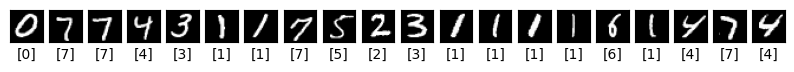

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))  # Adjusted size for 5 images in a row
for i in range(20):  # Looping only through the first 5 images
    plt.subplot(1, 20, i + 1)  # 1 row, 5 columns
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[ind2[i]].reshape(28, -1), cmap='gray')  # Assuming grayscale images
    plt.xlabel(y[ind2[i]])  # Display corresponding label
plt.show()


In [134]:
print(ind2)

[[2621], [288], [654], [5734], [695], [4248], [891], [4385], [7193], [6114], [8948], [13007], [11236], [1331], [12382], [1070], [16080], [11627], [19791], [11649]]


## Task 5 Evaluation & Report


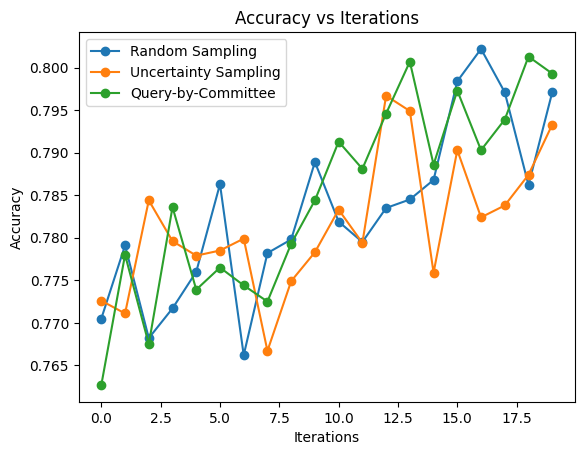

In [135]:
iterations=np.arange(0,20,1)

plt.plot(iterations,task1_results,label="Random Sampling",marker = "o")
plt.plot(iterations,task2_results,label="Uncertainty Sampling",marker = "o")
plt.plot(iterations,task4_results,label="Query-by-Committee",marker = "o")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iterations")
plt.legend()
plt.show()